<a href="https://colab.research.google.com/github/myth3107/image_classification/blob/main/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification with PyTorch
This notebook implements a CNN-based image classifier for the CIFAR-10 dataset.

In [ ]:
# Install required packages
!pip install torch torchvision numpy matplotlib pandas scikit-learn pillow tqdm seaborn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

## Define the CNN Model

In [ ]:
class ImageClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(ImageClassifier, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Max pooling
        self.pool = nn.MaxPool2d(2, 2)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # First conv block
        x = self.pool(F.relu(self.bn1(self.conv1(x))))

        # Second conv block
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        # Third conv block
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten
        x = x.view(-1, 128 * 4 * 4)

        # Fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

## Data Loading and Preprocessing

In [ ]:
# Class labels for CIFAR-10
CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

def get_data_transforms():
    """Define data transformations for training and testing"""
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    return train_transform, test_transform

def load_cifar10(batch_size=32, num_workers=2):
    """Load and prepare CIFAR-10 dataset"""
    train_transform, test_transform = get_data_transforms()

    # Download and load CIFAR-10
    train_dataset = datasets.CIFAR10(root='./data', train=True,
                                   download=True, transform=train_transform)

    test_dataset = datasets.CIFAR10(root='./data', train=False,
                                  download=True, transform=test_transform)

    # Split training data into train and validation
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                          shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader

# Load the datasets
train_loader, val_loader, test_loader = load_cifar10(batch_size=32, num_workers=2)

## Training Functions

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, device='cuda'):
    """Train the model and return training history"""
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        train_loss = train_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100. * correct / total
        val_loss = val_loss / len(val_loader)

        # Update learning rate
        scheduler.step(val_loss)

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')

    return history

## Model Training

In [29]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model, criterion, optimizer
model = ImageClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Train model
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, device=device)

Using device: cpu


Epoch 1/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 1/50:
Train Loss: 1.5255 | Train Acc: 44.30%
Val Loss: 1.3571 | Val Acc: 51.56%


Epoch 2/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 2/50:
Train Loss: 1.2115 | Train Acc: 56.45%
Val Loss: 1.0645 | Val Acc: 62.15%


Epoch 3/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 3/50:
Train Loss: 1.0745 | Train Acc: 61.89%
Val Loss: 0.9636 | Val Acc: 66.13%


Epoch 4/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 4/50:
Train Loss: 0.9904 | Train Acc: 65.11%
Val Loss: 0.8928 | Val Acc: 68.44%


Epoch 5/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 5/50:
Train Loss: 0.9317 | Train Acc: 67.20%
Val Loss: 0.8701 | Val Acc: 69.33%


Epoch 6/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 6/50:
Train Loss: 0.8837 | Train Acc: 68.89%
Val Loss: 0.8422 | Val Acc: 70.65%


Epoch 7/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 7/50:
Train Loss: 0.8448 | Train Acc: 70.70%
Val Loss: 0.8022 | Val Acc: 72.14%


Epoch 8/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 8/50:
Train Loss: 0.8113 | Train Acc: 71.78%
Val Loss: 0.7758 | Val Acc: 72.81%


Epoch 9/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 9/50:
Train Loss: 0.7912 | Train Acc: 72.67%
Val Loss: 0.7699 | Val Acc: 73.36%


Epoch 10/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 10/50:
Train Loss: 0.7582 | Train Acc: 73.79%
Val Loss: 0.7521 | Val Acc: 73.59%


Epoch 11/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 11/50:
Train Loss: 0.7394 | Train Acc: 74.39%
Val Loss: 0.7141 | Val Acc: 75.29%


Epoch 12/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 12/50:
Train Loss: 0.7228 | Train Acc: 74.69%
Val Loss: 0.7088 | Val Acc: 75.97%


Epoch 13/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 13/50:
Train Loss: 0.7035 | Train Acc: 75.56%
Val Loss: 0.6931 | Val Acc: 75.79%


Epoch 14/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 14/50:
Train Loss: 0.6884 | Train Acc: 76.27%
Val Loss: 0.7036 | Val Acc: 75.50%


Epoch 15/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 15/50:
Train Loss: 0.6768 | Train Acc: 76.62%
Val Loss: 0.6891 | Val Acc: 76.01%


Epoch 16/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 16/50:
Train Loss: 0.6590 | Train Acc: 77.06%
Val Loss: 0.6862 | Val Acc: 76.17%


Epoch 17/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 17/50:
Train Loss: 0.6525 | Train Acc: 77.43%
Val Loss: 0.6747 | Val Acc: 76.88%


Epoch 18/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 18/50:
Train Loss: 0.6426 | Train Acc: 77.76%
Val Loss: 0.6677 | Val Acc: 77.10%


Epoch 19/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 19/50:
Train Loss: 0.6293 | Train Acc: 78.20%
Val Loss: 0.6712 | Val Acc: 76.99%


Epoch 20/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 20/50:
Train Loss: 0.6254 | Train Acc: 78.11%
Val Loss: 0.6445 | Val Acc: 77.72%


Epoch 21/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 21/50:
Train Loss: 0.6110 | Train Acc: 78.93%
Val Loss: 0.6728 | Val Acc: 77.08%


Epoch 22/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 22/50:
Train Loss: 0.6073 | Train Acc: 79.06%
Val Loss: 0.6268 | Val Acc: 78.66%


Epoch 23/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 23/50:
Train Loss: 0.5923 | Train Acc: 79.59%
Val Loss: 0.6374 | Val Acc: 78.39%


Epoch 24/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 24/50:
Train Loss: 0.5831 | Train Acc: 79.56%
Val Loss: 0.6436 | Val Acc: 77.93%


Epoch 25/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 25/50:
Train Loss: 0.5777 | Train Acc: 79.97%
Val Loss: 0.6357 | Val Acc: 77.85%


Epoch 26/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 26/50:
Train Loss: 0.5734 | Train Acc: 80.01%
Val Loss: 0.6403 | Val Acc: 78.48%


Epoch 27/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 27/50:
Train Loss: 0.5673 | Train Acc: 80.18%
Val Loss: 0.6245 | Val Acc: 78.38%


Epoch 28/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 28/50:
Train Loss: 0.5588 | Train Acc: 80.70%
Val Loss: 0.6362 | Val Acc: 78.43%


Epoch 29/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 29/50:
Train Loss: 0.5522 | Train Acc: 80.85%
Val Loss: 0.6278 | Val Acc: 78.87%


Epoch 30/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 30/50:
Train Loss: 0.5441 | Train Acc: 80.91%
Val Loss: 0.6448 | Val Acc: 78.05%


Epoch 31/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 31/50:
Train Loss: 0.5464 | Train Acc: 80.86%
Val Loss: 0.6216 | Val Acc: 78.95%


Epoch 32/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 32/50:
Train Loss: 0.5362 | Train Acc: 81.22%
Val Loss: 0.6240 | Val Acc: 78.39%


Epoch 33/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 33/50:
Train Loss: 0.5331 | Train Acc: 81.15%
Val Loss: 0.6362 | Val Acc: 78.84%


Epoch 34/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 34/50:
Train Loss: 0.5234 | Train Acc: 81.70%
Val Loss: 0.6270 | Val Acc: 78.76%


Epoch 35/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 35/50:
Train Loss: 0.5211 | Train Acc: 81.84%
Val Loss: 0.6286 | Val Acc: 78.90%


Epoch 36/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 36/50:
Train Loss: 0.5162 | Train Acc: 81.86%
Val Loss: 0.6310 | Val Acc: 78.95%


Epoch 37/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 37/50:
Train Loss: 0.5113 | Train Acc: 82.26%
Val Loss: 0.6317 | Val Acc: 79.14%


Epoch 38/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 38/50:
Train Loss: 0.4576 | Train Acc: 84.04%
Val Loss: 0.5877 | Val Acc: 80.24%


Epoch 39/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 39/50:
Train Loss: 0.4402 | Train Acc: 84.67%
Val Loss: 0.5706 | Val Acc: 80.95%


Epoch 40/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 40/50:
Train Loss: 0.4298 | Train Acc: 84.90%
Val Loss: 0.5785 | Val Acc: 81.39%


Epoch 41/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 41/50:
Train Loss: 0.4306 | Train Acc: 85.00%
Val Loss: 0.5764 | Val Acc: 80.84%


Epoch 42/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 42/50:
Train Loss: 0.4199 | Train Acc: 85.38%
Val Loss: 0.5678 | Val Acc: 81.20%


Epoch 43/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 43/50:
Train Loss: 0.4100 | Train Acc: 85.58%
Val Loss: 0.5728 | Val Acc: 81.21%


Epoch 44/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 44/50:
Train Loss: 0.4119 | Train Acc: 85.44%
Val Loss: 0.5838 | Val Acc: 81.02%


Epoch 45/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 45/50:
Train Loss: 0.4092 | Train Acc: 85.66%
Val Loss: 0.5841 | Val Acc: 80.86%


Epoch 46/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 46/50:
Train Loss: 0.4093 | Train Acc: 85.64%
Val Loss: 0.5652 | Val Acc: 81.03%


Epoch 47/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 47/50:
Train Loss: 0.4101 | Train Acc: 85.36%
Val Loss: 0.5646 | Val Acc: 81.49%


Epoch 48/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 48/50:
Train Loss: 0.4016 | Train Acc: 85.90%
Val Loss: 0.5732 | Val Acc: 81.04%


Epoch 49/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 49/50:
Train Loss: 0.4037 | Train Acc: 85.80%
Val Loss: 0.5683 | Val Acc: 80.95%


Epoch 50/50:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 50/50:
Train Loss: 0.3964 | Train Acc: 86.00%
Val Loss: 0.5767 | Val Acc: 81.64%


## Visualize Training Results

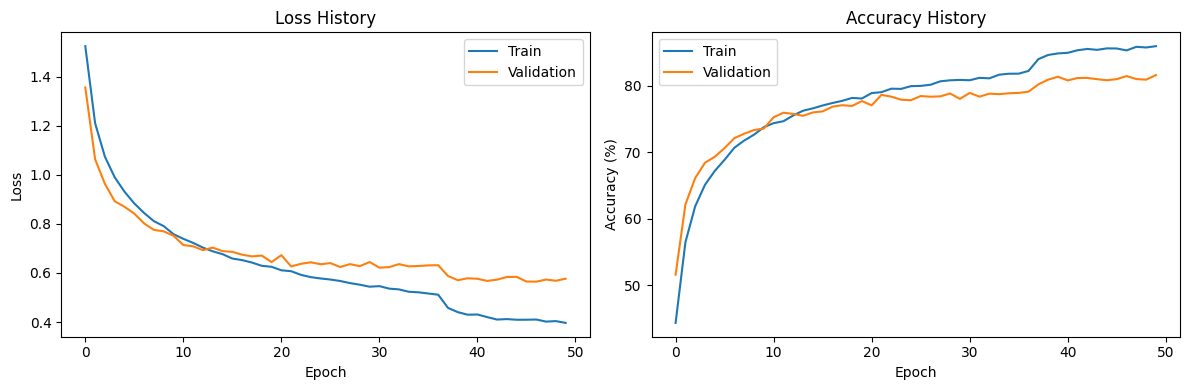

In [30]:
def plot_training_history(history):
    """Plot training history"""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Accuracy History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

## Model Evaluation

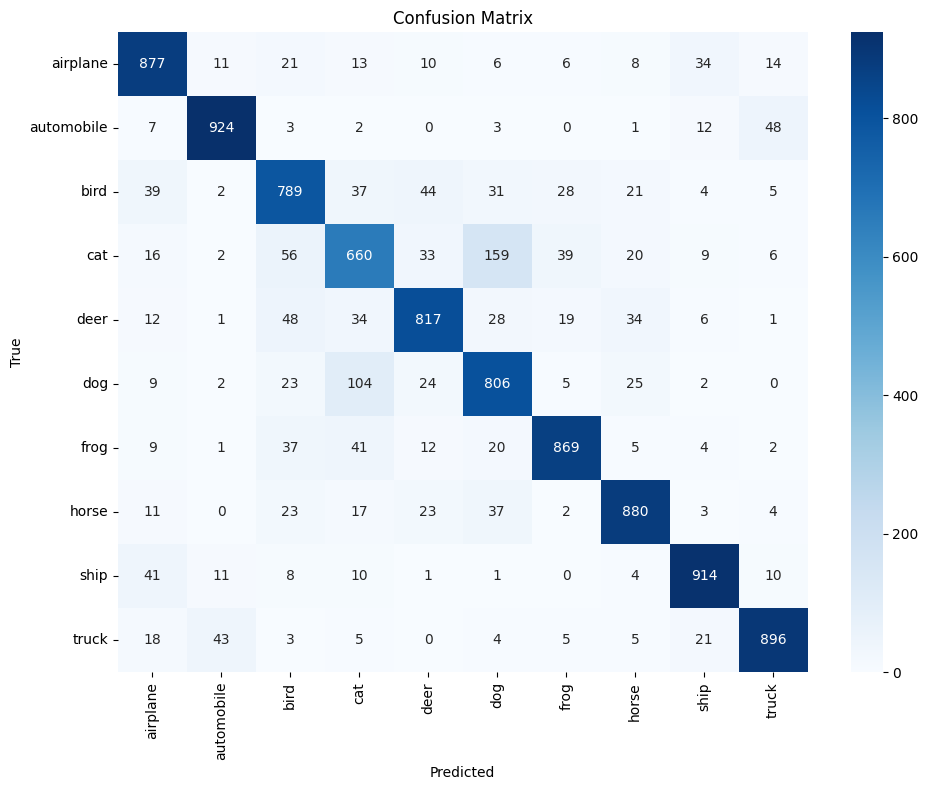


Classification Report:
              precision    recall  f1-score   support

    airplane       0.84      0.88      0.86      1000
  automobile       0.93      0.92      0.93      1000
        bird       0.78      0.79      0.78      1000
         cat       0.72      0.66      0.69      1000
        deer       0.85      0.82      0.83      1000
         dog       0.74      0.81      0.77      1000
        frog       0.89      0.87      0.88      1000
       horse       0.88      0.88      0.88      1000
        ship       0.91      0.91      0.91      1000
       truck       0.91      0.90      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [31]:
def evaluate_model(model, test_loader, device='cuda'):
    """Evaluate model and generate confusion matrix"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=CLASSES))

# Evaluate the model
evaluate_model(model, test_loader, device)

## Save the Model (Optional)

In [32]:
# Save model
torch.save(model.state_dict(), 'cifar10_model.pth')
print("Model saved successfully!")

Model saved successfully!
